In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import torch
import torch.nn as nn
import torch.optim as optim
import os
import torchvision
from torchvision import transforms
import cv2

In [2]:
trained_model = torchvision.models.mobilenet_v2(pretrained=True)
trained_model.classifier[1] = nn.Sequential(
    nn.Linear(1280, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(32, 2),
)

trained_model.load_state_dict(torch.load('Trained Models/mask_detection_model.pth'))
trained_model.eval()
print("Trained Model Loaded")


Trained Model Loaded


In [3]:
image = cv2.imread('examples/example_01.png')
og_image = image.copy()
(h, w) = image.shape[:2]

In [4]:
blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300))

(-0.5, 599.5, 499.5, -0.5)

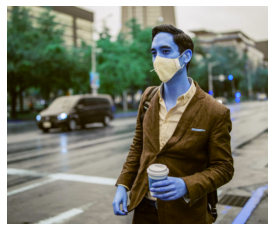

In [5]:
plt.imshow(image)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 299.5, 299.5, -0.5)

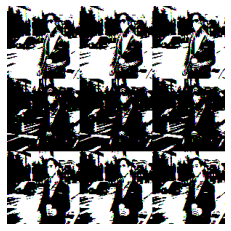

In [6]:
blob_image = blob.reshape(blob.shape[2], blob.shape[3], blob.shape[1])
plt.imshow(blob_image)
plt.axis('off')

In [7]:
print(image.shape)
print(blob.shape)

(500, 600, 3)
(1, 3, 300, 300)


In [8]:
# Loading Face Detector Model, to detect face from image
net = cv2.dnn.readNetFromCaffe('Trained Models/face_detector/deploy.prototxt', 'Trained Models/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

In [9]:
# Detecting face from the image
net.setInput(blob)
detections = net.forward()

In [10]:
CONFIDENCE = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
from PIL import Image
test_transform_compose = transforms.Compose({
    transforms.Resize((320,320)),
    transforms.ToTensor(),
})

In [12]:
def prepare_image_for_testing(img):
    img = Image.fromarray(img)
    img = test_transform_compose(img)
    img = img.unsqueeze_(0)
    return img

Label: 0


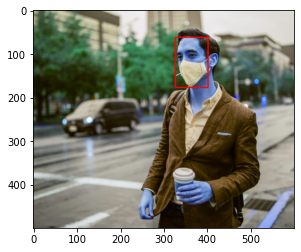

In [14]:
for i in range(0,detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > CONFIDENCE:
        box = detections[0, 0, i, 3:7]*np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (320, 320))
        cv2.imwrite('outputs/cropped_example01.jpg', face)
        # Now feeding to mask model
        # face = img_to_array(face)
        # face = preprocess_input(face)
        # face = np.expand_dims(face, axis=0)
        
        
        
        face = prepare_image_for_testing(face)
        face = face.to(device=device)
        trained_model.to(device=device)
        pred_output = trained_model(face)
        _, prediction = pred_output.max(1)
        print("Label: 0")
        if (prediction[0]==0):
            label = "Mask"
        else:
            label = "No Mask"
        # (mask, withoutMask) = t.predict(face)[0]
        
        color = (0,255,0) if label == "Mask" else (255,0,0)
    
#         label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        
#         cv2.putText(image, label, (w-110, h-10),
# 			cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

plt.imshow(image)